In [19]:
# Import pandas for data processing
import pandas as pd

files = ["cond.csv", "contr.csv", "rephrased.csv", "spelling.csv", "training.csv"]
dfs = []
for file in files:
    df = pd.read_csv("blog_data/" + file)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# Convert the "result" column to numeric classes
data["label"] = data["result"].map({"complaints": 2, "returns": 1, "pricing": 0})

In [20]:
test_data = pd.read_csv("blog_data/testing.csv")

# Convert the "result" column to numeric classes
test_data["label"] = test_data["result"].map({"complaints": 2, "returns": 1, "pricing": 0})

In [21]:
data.head()

,input,result,label
0,"Given the market trends, how frequently are yo...",pricing,0
1,"Considering the fluctuations in market trends,...",pricing,0
2,"In the event that market trends change, how of...",pricing,0
3,"Considering Product X, why is its price higher...",pricing,0
4,"Given the pricing of Product X, can you explai...",pricing,0


In [22]:
# Load a DistilBERT model and tokenizer
from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Load libraries for PyTorch
import torch
from torch.utils.data import DataLoader

# Split the data into training and validation sets
train_data = data.sample(frac=0.8)
val_data = data.drop(train_data.index)

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

# Create a custom dataset class for the text data
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, device):
        self.data = data
        self.tokenizer = tokenizer
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the text and label for the given index
        text = self.data.iloc[idx]["input"]
        label = self.data.iloc[idx]["label"]

        # Tokenize the text
        encoding = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

        # Return the input IDs, attention mask, and label (reshape the input IDs and attention mask to remove an unneeded dimension)
        return encoding.input_ids.squeeze(), encoding.attention_mask.squeeze(), label

# Create Dataset objects for the training and validation sets
train_dataset = TextDataset(train_data, tokenizer, device)
val_dataset = TextDataset(val_data, tokenizer, device)
test_dataset = TextDataset(test_data, tokenizer, device)

# Create DataLoader objects for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [24]:
from tqdm import tqdm
# An optimizer for the model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# One epoch of training
def train(loader, model, optimizer):
    # Set the model to training mode
    model.train()
    print("Training...")
    losses = []
    for input_ids, attention_mask, labels in tqdm(loader):
        optimizer.zero_grad()
        # One-hot encode the labels
        oh_labels = torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32).to(device)
        # Pass the input IDs, attention mask, and one-hot labels to the model and get the loss
        loss = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), labels=oh_labels).loss
        # Backpropagate the loss
        loss.backward()
        # Update the model parameters
        optimizer.step()
        # Track losses
        losses.append(loss.item())
    return losses

# One epoch of validation
def validate(loader, model, epoch):
    # Set the model to evaluation mode
    model.eval()
    print("Validating...")
    # Disable gradient calculations (not needed for validation)
    with torch.no_grad():
        correct = 0
        total = 0
        losses = []
        for input_ids, attention_mask, labels in loader:
            # One-hot encode the labels
            oh_labels = torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32)
            # Pass the input IDs and attention mask to the model and get the logits and loss
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=oh_labels)
            logits = output.logits
            loss = output.loss
            # Get the predicted labels
            predictions = torch.argmax(logits, dim=1)
            # Track accuracy
            correct += (predictions == labels).sum().item()
            total += len(labels)
            # Track losses
            losses.append(loss.item())
        accuracy = correct / total
        print(f"Epoch {epoch}, Validation Accuracy: {accuracy}")
    
    return losses

Training...


100%|██████████| 100/100 [16:34<00:00,  9.95s/it]


Validating...
Epoch 0, Validation Accuracy: 1.0


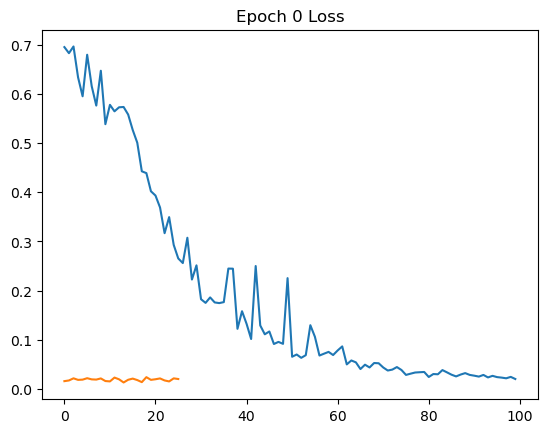

In [25]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Train the model for 1 epoch
train_losses = []
val_losses = []
for epoch in range(1):
    # Train the model for one epoch
    losses = train(train_loader, model, optimizer)
    train_losses.extend(losses)
    # Validate the model
    val_loss = validate(val_loader, model, epoch)
    val_losses.extend(val_loss)

# Plot the loss
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title(f"Epoch {epoch} Loss")
plt.show()

In [26]:
# Save the model locally
model.save_pretrained("blog_model_synthetic")